In [17]:
import pandas as pd
import numpy as np
import wave
import os
import shutil
import subprocess
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import rfft, rfftfreq
from pathlib import Path

In [2]:
data_root = Path("../raw_data/audio")

In [3]:
all_files = list(data_root.glob('*/*.wav'))

In [53]:
%%time
## Convert the raw data to 16k 16bit 1ch PCM WAVE and save them in the package data folder
## we use ffmpeg since the data includes ADPCM files that are not supported by scipy.io or stdlib wave
for i,p in enumerate(all_files):
    outpath = Path('../us8kdata/data') / os.path.join(*p.parts[-2:])
    if not outpath.parent.exists():
        outpath.parent.mkdir()
    if i % 100 == 0:
        print(i, outpath)
    if not outpath.exists():
        subprocess.run(f'ffmpeg -i {p.as_posix()} -ar 16000 -ac 1 -c:a pcm_s16le {outpath.as_posix()}',
                       shell=True,
                      stdout=subprocess.DEVNULL,
                      stderr=subprocess.STDOUT)

0 ../us8kdata/data/fold2/203929-7-5-1.wav
100 ../us8kdata/data/fold2/74507-0-0-10.wav
200 ../us8kdata/data/fold2/123688-8-0-14.wav
300 ../us8kdata/data/fold2/147926-0-0-27.wav
400 ../us8kdata/data/fold2/40717-8-0-6.wav
500 ../us8kdata/data/fold2/115537-3-0-0.wav
600 ../us8kdata/data/fold2/84359-2-0-1.wav
700 ../us8kdata/data/fold2/158607-3-1-0.wav
800 ../us8kdata/data/fold2/201652-5-4-6.wav
900 ../us8kdata/data/fold5/159439-2-0-21.wav
1000 ../us8kdata/data/fold5/108357-9-0-2.wav
1100 ../us8kdata/data/fold5/203913-8-0-1.wav
1200 ../us8kdata/data/fold5/118440-4-1-0.wav
1300 ../us8kdata/data/fold5/156869-8-0-4.wav
1400 ../us8kdata/data/fold5/104998-7-0-5.wav
1500 ../us8kdata/data/fold5/178260-7-2-0.wav
1600 ../us8kdata/data/fold5/164782-8-0-5.wav
1700 ../us8kdata/data/fold5/91533-5-0-0.wav
1800 ../us8kdata/data/fold5/104998-7-8-17.wav
1900 ../us8kdata/data/fold4/140824-4-0-0.wav
2000 ../us8kdata/data/fold4/169466-4-3-14.wav
2100 ../us8kdata/data/fold4/22883-7-44-0.wav
2200 ../us8kdata/dat

In [18]:
## extract relevant metadata and copy it to data folder
metadata_df = pd.read_csv('../raw_data/metadata/UrbanSound8K.csv')
metadata_outpath = Path('../us8kdata/data/metadata/urbansound8K.csv')
if not metadata_outpath.parent.exists():
    metadata_outpath.parent.mkdir()
metadata_df[['slice_file_name', 'salience', 'fold', 'classID', 'class']].to_csv(metadata_outpath, index=False)

In [5]:
metadata_df['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [62]:
len(metadata_df)

8732

In [6]:
def path_builder(fname, fold):
    return Path(f'../us8kdata/data/fold{fold}/{fname}')

In [7]:
metadata_df.iloc[:,-2:].drop_duplicates()

,classID,class
0,3,dog_bark
1,2,children_playing
9,1,car_horn
22,0,air_conditioner
94,9,street_music
106,6,gun_shot
114,8,siren
122,5,engine_idling
171,7,jackhammer
196,4,drilling


In [72]:
tsr, twav = wavfile.read(path_builder(*metadata_df.iloc[0,[0,-3]]))

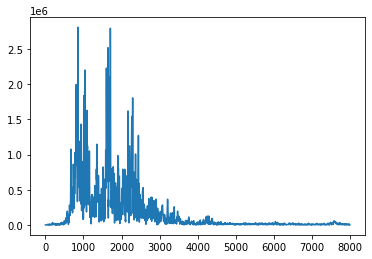

In [76]:
ty = rfft(twav)
tx = rfftfreq(twav.shape[0], 1/tsr)

plt.plot(tx, np.abs(ty))

In [8]:
def get_class_std_length_spectrums(classID):
    spectrums = []
    max_len = 0 # 4s
    for idx, row in metadata_df.query('classID == @classID').iterrows():
        tmp_sr, tmp_wav = wavfile.read(path_builder(row[0], row[-3]))
        if (wav_len := tmp_wav.shape[0]) > max_len:
            max_len = wav_len
    for idx, row in metadata_df.query('classID == @classID').iterrows():
        tmp_sr, tmp_wav = wavfile.read(path_builder(row[0], row[-3]))
        spectrums.append(rfft(np.pad(tmp_wav, (max_len - tmp_wav.shape[0],0))))
    
    spectrums = np.array(spectrums)
    return max_len, tmp_sr, spectrums
                                      


In [9]:
def plot_class_mean_spectrum(classID, ax=None, hpf=None, lpf=None):
    class_name = metadata_df.query('classID == @classID').iloc[0]['class']
    max_len, sr, spectrums = get_class_std_length_spectrums(classID)
    pow_spec = np.abs(spectrums)
    #pow_spec = pow_spec / pow_spec.max(axis=0)
    #pow_std = pow_spec.std(axis=0)
    pow_mean = pow_spec.mean(axis=0)
    #plt.plot(rfftfreq(max_len, 1/sr), pow_mean + pow_std, )
    freq_bins = rfftfreq(max_len, 1/sr)
    hpf if hpf else freq_bins.min()
    lpf = lpf if lpf else freq_bins.max()
    filter_mask = (freq_bins > hpf) & (freq_bins < lpf)
    if ax is None:
        plt.plot(freq_bins[filter_mask], pow_mean[filter_mask])
        plt.title(class_name)
    else:
        ax.plot(freq_bins[filter_mask], pow_mean[filter_mask])
        ax.set_title(class_name)
    #plt.plot(rfftfreq(max_len, 1/sr), pow_mean - pow_std)

In [96]:
max_len
#set(map(len, spectrums))
spectrums.shape

(429, 32001)

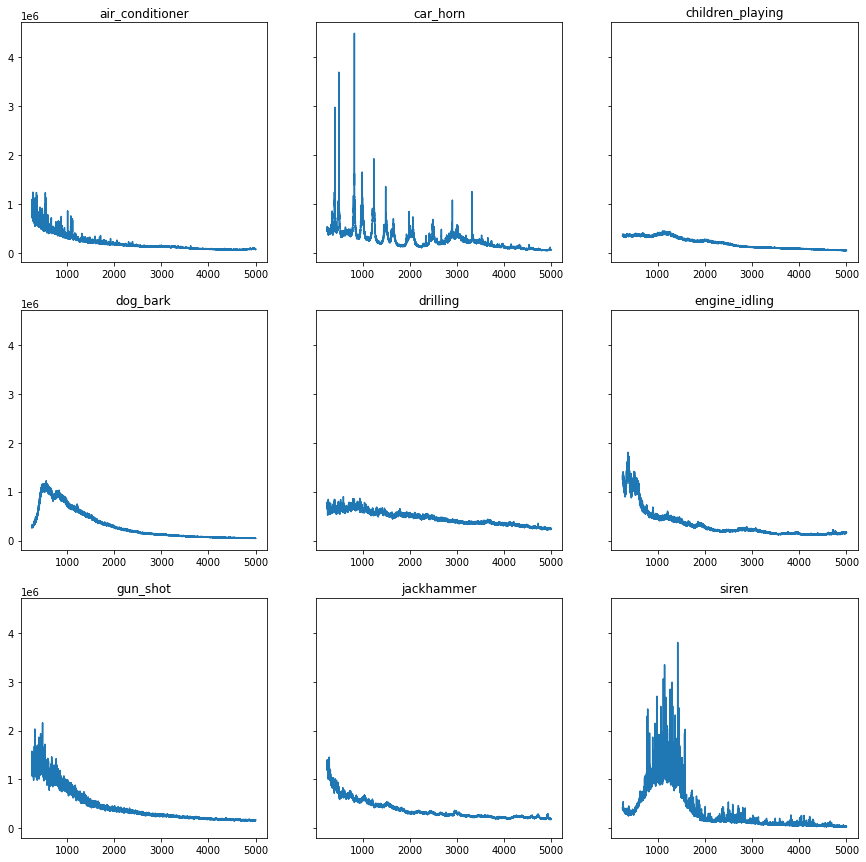

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(15,15), sharey=True)
for classID, ax in zip(range(10), axes.flat):
    plot_class_mean_spectrum(classID, ax, hpf=250, lpf=5000)


In [10]:
sr, samples = wavfile.read('../us8kdata/data/fold1/101415-3-0-3.wav')

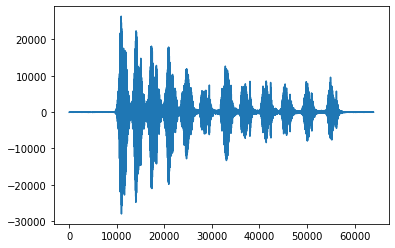

In [13]:
plt.plot(samples)

In [14]:
tfft = rfft(samples)

In [15]:
tfreqs = rfftfreq(len(samples), 1/sr)

In [ ]:
plt.plot(tfreqs, np.abs(tfft))

In [ ]:
MFCC Mel Frequency Cepstrum Coefficient

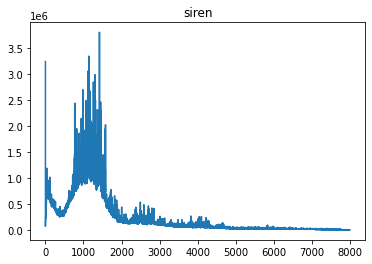

In [15]:
plot_class_mean_spectrum(8)

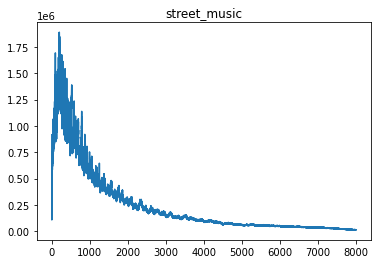

In [16]:
plot_class_mean_spectrum(9)